# Time Series - Double Exponential Smoothing (DES)

In [1]:
import numpy as np
import pandas as pd

In [110]:
import util as u

In [3]:
base_path = "data/I88N-processed/"

In [5]:
# import concatenated data, and available days to sample from
concat_1 = pd.read_csv(base_path + "concat/concat_1.csv")
concat_2 = pd.read_csv(base_path + "concat/concat_2.csv")
concat_3 = pd.read_csv(base_path + "concat/concat_3.csv")

In [57]:
datetime_1 = concat_1["datetime"].values
datetime_1 = pd.to_datetime(datetime_1)

In [196]:
dataset_df_1 = concat_1.loc[concat_1["Date"].isin(dates_format_1)]

In [197]:
dataset_df_2 = concat_2.loc[concat_2["Date"].isin(dates_format_2)]
dataset_df_3 = concat_3.loc[concat_3["Date"].isin(dates_format_2)]

In [202]:
dataset_df_2["Station ID"].unique()

array([400141, 400761, 400490, 401888, 400137, 400716, 401545, 401011,
       400674, 400539, 400534, 401062, 401529, 401613, 400536, 400488,
       401561, 400611, 400928, 400284, 400041, 408133, 408135, 417665,
       412637, 417666, 408134, 400685, 401003, 400898, 400275, 400939,
       400180, 400529, 400990])

In [205]:
len(dataset_df_2.loc[dataset_df_2["Station ID"] == 417666].values)

64512

In [200]:
dates = available_dates

In [206]:
len(dates)

224

The total number of samples collected at one station across all days is 97344, which is equal to 338 days * 24 hours/day * 12 samples/hour.

In [260]:
dataset_df_1.head(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
33395,408907,2017-04-30 00:00:00,0.6,26.0,68.4,04/30/2017,00:00,33395
33396,408907,2017-04-30 00:05:00,1.1,42.0,67.5,04/30/2017,00:05,33396
33397,408907,2017-04-30 00:10:00,1.0,41.0,68.1,04/30/2017,00:10,33397


In [207]:
dataset_df_1.to_csv(base_path + "concat_no_holes/concat_1.csv")
dataset_df_2.to_csv(base_path + "concat_no_holes/concat_2.csv")
dataset_df_3.to_csv(base_path + "concat_no_holes/concat_3.csv")

In [262]:
concats = [dataset_df_1, dataset_df_2, dataset_df_3]

In [263]:
concat = pd.concat(concats)

In [264]:
concat.to_csv(base_path + "concat_no_holes/concat.csv")

In [220]:
available_dates_str = pd.read_csv(base_path + "available_dates.csv").iloc[:, 0].values

In [221]:
available_dates_str[:3]

array(['2017-04-30', '2017-05-01', '2017-05-02'], dtype=object)

In [222]:
dates = list(map(lambda x: pd.to_datetime(x).date(), available_dates_str))

In [265]:
dataset_df_1.head(1)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
33395,408907,2017-04-30 00:00:00,0.6,26.0,68.4,04/30/2017,00:00,33395


In [266]:
dataset_df_2.head(1)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
33396,400141,2017-04-30 00:00:00,2.7,175.0,68.1,04/30/2017,00:00,33396


In [267]:
dataset_df_3.tail(1)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
3252717,401471,2017-12-30 23:55:00,4.0,210.0,60.8,12/30/2017,23:55,3252717


In [268]:
dates[0:2]

[datetime.date(2017, 4, 30), datetime.date(2017, 5, 1)]

In [269]:
dates_format_1 = available_dates_str

In [270]:
dates_format_1[0:3]

array(['2017-04-30', '2017-05-01', '2017-05-02'], dtype=object)

In [226]:
dates_format_2 = list(map(lambda x: x.split('-')[1] + "/" + x.split('-')[2] + "/" + x.split('-')[0], available_dates_str))

In [271]:
dates_format_2[0:3]

['04/30/2017', '05/01/2017', '05/02/2017']

## Exception found: we want the dates to start from 2017-04-30

In [191]:
available_dates[0:10]

array(['2017-04-30', '2017-05-01', '2017-05-02', '2017-05-03',
       '2017-05-04', '2017-05-06', '2017-05-07', '2017-05-08',
       '2017-05-09', '2017-05-10'], dtype=object)

In [188]:
pd.DataFrame(available_dates).to_csv(base_path + "available_dates.csv", index=False)

# Is there any temporal correlation in the data?  Visulize data at one station, in one day

In [289]:
import matplotlib.pyplot as plt

In [272]:
stations = concat["Station ID"].unique()

There is a problem here.  The two stations, 417665 and 417666, have records starting from 2007-04-29, and started to collect data on 2007-04-30 (notice that speed, flow and occupancy are all constant on 2007-04-29).  Therefore we discard the data before date 2007-04-29.

In [277]:
len(dates)

224

Finally, there are 224 days of data available for use, and the total number of records for each station is 64512.

In [279]:
len(stations)

102

In [280]:
stations[0:10]

array([408907, 400951, 400057, 400147, 400343, 401560, 400045, 400122,
       401541, 402281])

In [381]:
sample_station = np.random.choice(stations)
sample_date = np.random.choice(dates)
sample_date2 = np.random.choice(dates)

In [382]:
print(sample_station, sample_date, sample_date2)

400284 2017-11-17 2017-09-30


In [383]:
sample_df = concat.loc[(concat["Station ID"] == sample_station) & (concat["Date"] == sample_date.strftime("%m/%d/%Y"))]
sample_df2 = concat.loc[(concat["Station ID"] == sample_station) & (concat["Date"] == sample_date2.strftime("%m/%d/%Y"))]

### Occupancy (%)

In [384]:
sample_x = sample_df["Time"].values

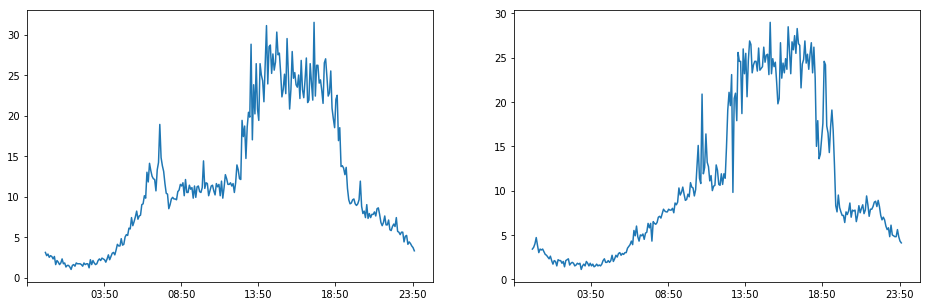

In [385]:
sample_occ = sample_df["Occupancy"].values
sample_occ2 = sample_df2["Occupancy"].values

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.plot(sample_x, sample_occ)
ax2.plot(sample_x, sample_occ2)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 60))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 60))

plt.show()

### Flow (number of cars / 5 minutes)

<Figure size 432x288 with 0 Axes>

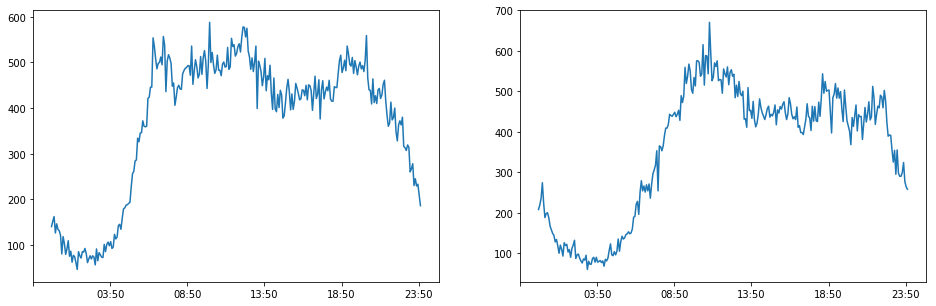

In [386]:
sample_flow = sample_df["Flow"].values
sample_flow2 = sample_df2["Flow"].values

plt.clf()
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.plot(sample_x, sample_flow)
ax2.plot(sample_x, sample_flow2)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 60))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 60))

plt.show()

### Speed (mph)

<Figure size 432x288 with 0 Axes>

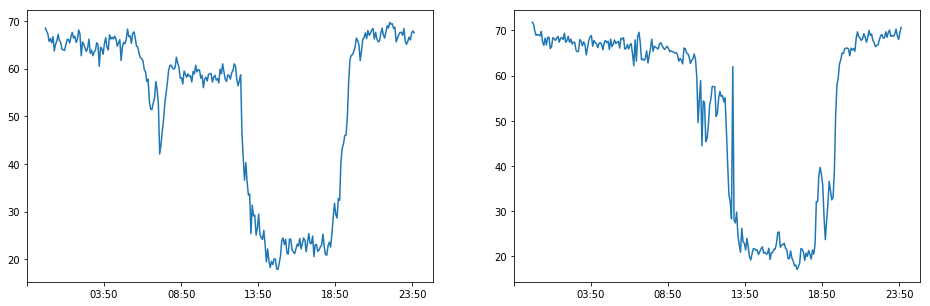

In [387]:
sample_speed = sample_df["Speed"].values
sample_speed2 = sample_df2["Speed"].values

plt.clf()
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.plot(sample_x, sample_speed)
ax2.plot(sample_x, sample_speed2)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 60))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 60))

plt.show()

# Bootstrapping data

TODO: One idea - we can keep a rational proportion between weekdays and weekends in the sample data.

In [388]:
len(dates)

224

In [391]:
dates_train = np.random.choice(dates, 112)

In [392]:
dates_test = list(set(dates).difference(set(dates_train)))
dates_test.sort()

In [395]:
len(dates_train), len(dates_test)

(112, 138)

In [403]:
dates_train_str = list(map(lambda x: x.strftime("%m/%d/%Y"), dates_train))
dates_test_str = list(map(lambda x: x.strftime("%m/%d/%Y"), dates_test))
dates_train_str.sort()
dates_test_str.sort()

In [405]:
dates_train_str[:3], dates_test_str[:3]

(['05/04/2017', '05/04/2017', '05/07/2017'],
 ['04/30/2017', '05/01/2017', '05/02/2017'])

In [406]:
df_train = concat.loc[concat["Date"].isin(dates_train_str)]
df_test = concat.loc[concat["Date"].isin(dates_test_str)]

In [408]:
df_train.head(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
34547,408907,2017-05-04 00:00:00,0.6,20.0,67.6,05/04/2017,00:00,34547
34548,408907,2017-05-04 00:05:00,0.5,18.0,67.9,05/04/2017,00:05,34548
34549,408907,2017-05-04 00:10:00,0.5,20.0,68.3,05/04/2017,00:10,34549


In [409]:
df_test.head(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
33395,408907,2017-04-30 00:00:00,0.6,26.0,68.4,04/30/2017,00:00,33395
33396,408907,2017-04-30 00:05:00,1.1,42.0,67.5,04/30/2017,00:05,33396
33397,408907,2017-04-30 00:10:00,1.0,41.0,68.1,04/30/2017,00:10,33397


## DES: Tune and save parameters for each variable, and each detector station

$$S_1(t) = \alpha X(i,t) + (1 - \alpha) S_1(t-1)$$
$$S_2(t) = \alpha S_1(t) + (1 - \alpha) S_2(t-1)$$
$$A(t) = 2S_1(t) - S_2(t)$$
$$B(t) = \frac{\alpha}{1 - \alpha} [S_1(t) - S_2(t)]$$
and finally,
$$Y(i, t+1) = A(i, t) + B(i, t),$$
where $i$ denotes a detector station named $i$.

In [411]:
station = np.random.choice(stations)

In [412]:
station

401003

In [413]:
df_train_station = df_train.loc[df_train["Station ID"] == station]

In [416]:
df_train_station.head(5)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx
2814457,401003,2017-05-04 00:00:00,1.9,220.0,67.1,05/04/2017,00:00,2814457
2814458,401003,2017-05-04 00:05:00,1.8,208.0,67.5,05/04/2017,00:05,2814458
2814459,401003,2017-05-04 00:10:00,2.3,252.0,66.9,05/04/2017,00:10,2814459
2814460,401003,2017-05-04 00:15:00,1.3,155.0,68.8,05/04/2017,00:15,2814460
2814461,401003,2017-05-04 00:20:00,1.5,181.0,69.1,05/04/2017,00:20,2814461


In [427]:
var_name = "Occupancy"
var_series = df_train_station[var].values

In [428]:
var_series[:5]

array([1.9, 1.8, 2.3, 1.3, 1.5])

In [431]:
# initialize data using the first ten points
alphas = np.arange(1000) / 1000.
# for each alpha, perform exponential smoothing, and compute RMSE
alpha = np.random.choice(alphas)
beta = round(1. - alpha, 3)

In [432]:
alpha, beta

(0.271, 0.729)

In [421]:
s1 = [0.] * len(var_series)
s2 = [0.] * len(var_series)
y = [0.] * len(var_series)

In [423]:
len(var_series)

24768

In [426]:
# initialize values
s1[10] = np.mean(var_series[:10])
s2[10] = s1[10]

In [459]:
for i in range(11, len(var_series)):
    y[i] = 2 * s1[i-1] - s2[i-1] + alpha / beta * (s1[i-1] - s2[i-1])
    s1[i] = alpha * var_series[i-1] + beta * s1[i-2]
    s2[i] = alpha * s1[i-1] + beta * s2[i-2]

In [461]:
# compute RMSE
diff = var_series - y
diff = diff[11:len(var_series)]

In [462]:
rmse = np.sqrt( np.mean(diff ** 2) )

## Put the above code together!

We also want to save the best alphas for each variable. Use a dictionary, transform it to pandas dataframe, and save to csv.

In [465]:
var_names = ["Speed", "Flow", "Occupancy"]

In [ ]:
best_alphas = {
    'Station ID': [],
    'Speed': [],
    'Flow': [],
    'Occupancy': []
}
num_grids = 10
for i, station in enumerate(stations):
    best_alphas['Station ID'].append(station)
    # update current training station dataframe
    df_train_station = df_train.loc[df_train["Station ID"] == station]
    print(station)
    for var_name in var_names:
        var_series = df_train_station[var_name].values
        len_series = len(var_series)
        
        # setting up alphas
        alphas = np.arange(num_grids) * 1. / num_grids
        
        # save the historical best alpha by rmse
        best_rmse = float("inf")
        best_alpha = 0.
        
        # for each alpha, perform exponential smoothing, and compute RMSE
        for alpha in alphas:
            beta = round(1. - alpha, 3)
            s1 = [0.] * len_series
            s2 = [0.] * len_series
            y = [0.] * len_series
            
            # initialize values
            s1[10] = np.mean(var_series[:10])
            s2[10] = s1[10]
            
            # time series prediction
            for t in range(11, len_series):
                y[t] = 2 * s1[t-1] - s2[t-1] + alpha / beta * (s1[t-1] - s2[t-1])
                s1[t] = alpha * var_series[t-1] + beta * s1[t-2]
                s2[t] = alpha * s1[t-1] + beta * s2[t-2]
            
            # compute RMSE
            diff = var_series - y
            diff = diff[11:len(var_series)]
            rmse = np.sqrt( np.mean(diff ** 2) )
            
            # compare, and decide whether to update best alpha
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
        
        # finally, save the best alpha for the variable at this station
        best_alphas[var_name].append(best_alpha)
    
    # print trained alphas for each station
    print(best_alphas['Station ID'][i], best_alphas['Speed'][i], best_alphas['Flow'][i], best_alphas['Occupancy'][i])

408907
408907 0.4 0.2 0.3
400951
400951 0.4 0.2 0.3
400057
